In [1]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf

2024-04-15 13:42:05.735838: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 13:42:05.756965: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 13:42:05.756986: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 13:42:05.757000: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 13:42:05.761246: I tensorflow/core/platform/cpu_feature_g

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Loading the Data

In [ ]:
from google.colab import files
uploaded = files.upload()

In [2]:
from Loss_functions import dice_loss, jaccard_loss, binary_cross_entropy


In [ ]:
lambda_ = 0.8
def custom_loss(y_true, y_pred):
  return lambda_ * dice_loss(y_true, y_pred) + (1 - lambda_) * binary_cross_entropy(y_true, y_pred)
# custom_loss = custom_loss(y_true, y_pred)

In [3]:
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)


""" set random seed """
def set_random_seed(seed = 42):
  tf.random.set_seed(seed)
  np.random.seed(seed)

""" Folder for saving the data """
create_dir('/home/interns/Desktop/sandipan/Unet_Model_Files')

""" set random seed """
set_random_seed(42)

""" Hyperparameters """
batch_size = 16
num_epochs = 100
lr = 1e-4
model_path = '/home/interns/Desktop/sandipan/Unet_Model_Files/model_x1.h5'
csv_path = '/home/interns/Desktop/sandipan/Unet_Model_Files/data_x1.csv'

In [4]:
""" Hyperparameters """
batch_size = 2
num_epochs = 50
lr = 1e-4

In [5]:
""" Load the Data : 80/20"""

def load_data(dataset_path, split = 0.2):
  """ Load the data """
  images = sorted(os.listdir(os.path.join(dataset_path, 'Images')))
  masks = sorted(os.listdir(os.path.join(dataset_path, 'Masks')))
  images = [os.path.join(dataset_path,'Images', image) for image in images]
  masks = [os.path.join(dataset_path, 'Masks', mask) for mask in masks]

  print(len(images))
  print(len(masks))
  test_size = int(len(images) * split)
  train_x, valid_x = train_test_split(images, test_size = test_size, random_state = 42)
  train_y, valid_y = train_test_split(masks, test_size = test_size, random_state = 42)
  train_x = np.array(train_x)
  train_y = np.array(train_y)
  valid_x = np.array(valid_x)
  valid_y = np.array(valid_y)

  return (train_x, train_y), (valid_x, valid_y)


dataset_path = "/home/interns/Desktop/sandipan/OPMD_FULL_SIZE/Test_Train/Train"
(train_x, train_y), (test_x, test_y) = load_data(dataset_path)

print(f"Number of training examples: {len(train_x)}")
print(f"Number of validation examples: {len(test_x)}")




1124
1124
Number of training examples: 900
Number of validation examples: 224


In [ ]:
print(train_x)
print(train_y)

In [6]:
print(len(train_x))
print(len(train_y))

900
900


In [7]:
""" Read the Images and masks """

def read_image(path):
  path = path.decode()
  image = cv.imread(path, cv.IMREAD_COLOR)   # (256,256,3)
  image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  x = image/255.0
  x = x.astype(np.float32)
  return x

def read_mask(path):
  path = path.decode()
  image = cv.imread(path, cv.IMREAD_GRAYSCALE)   # (256,256)
  x = image/255.0
  x = x.astype(np.float32)
  x = np.expand_dims(x, axis = -1) # (256,256,1)
  return x


""" converting to the functions to tensor """

def tf_parse(x, y):
  def _parse(x, y):
    x = read_image(x)
    y = read_mask(y)
    return x, y
  x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
  x.set_shape([256, 256, 3])
  y.set_shape([256, 256, 1])
  return x, y


def tf_dataset(X, Y, batch_size = 1):
  dataset = tf.data.Dataset.from_tensor_slices((X, Y))
  dataset = dataset.map(tf_parse)
  dataset = dataset.batch(batch_size)
  return dataset



In [8]:
train_dataset = tf_dataset(train_x, train_y, batch_size = batch_size)
test_dataset = tf_dataset(test_x, test_y, batch_size = batch_size)

train_steps = len(train_x) // batch_size
test_steps = len(test_x) // batch_size

if len(train_x) % batch_size != 0:
  train_steps += 1
if len(test_x) % batch_size != 0:
  test_steps += 1

2024-04-15 13:42:31.339346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 13:42:31.371923: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 13:42:31.372035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2024-04-15 13:42:44.759681: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


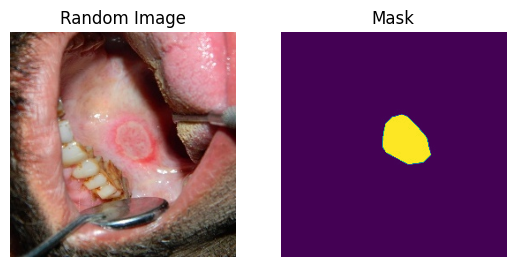

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming train_dataset is your TensorFlow dataset containing batches of image-mask pairs

# Shuffle the dataset
shuffled_dataset = train_dataset.shuffle(buffer_size=len(train_x))

# Take one batch from the shuffled dataset
random_batch = next(iter(shuffled_dataset))

# Select a random index within the batch
random_index = np.random.randint(0, len(random_batch[0]))

# Extract the random image and its mask from the batch
random_image = random_batch[0][random_index]  # Assuming images are in the first element of the batch
random_mask = random_batch[1][random_index]   # Assuming masks are in the second element of the batch

# Plot the random image
plt.subplot(1, 2, 1)
plt.imshow(random_image.numpy())  # Convert from TensorFlow tensor to numpy array
plt.title('Random Image')
plt.axis('off')

# Plot the corresponding mask
plt.subplot(1, 2, 2)
plt.imshow(random_mask.numpy())  # Convert from TensorFlow tensor to numpy array
plt.title('Mask')
plt.axis('off')

plt.show()


In [ ]:
""" Unet Model """

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def Conv2D_block(inputs, num_filters):
  x = Conv2D(num_filters, 3, padding = 'same')(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(num_filters, 3, padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

def encoder_block(inputs, num_filters):
  x = Conv2D_block(inputs, num_filters)
  p = MaxPool2D((2, 2))(x)
  return x, p

def decoder_block(inputs, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2, 2), strides = 2, padding = 'same')(inputs)
  x = Concatenate()([x, skip_features])
  x = Conv2D_block(x, num_filters)
  return x

def UNet(input_shape):
  inputs = Input(input_shape)

  """ Encoder """
  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  """ Bridge """
  b1 = Conv2D_block(p4, 1024)

  """ Decoder """
  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  """ Output Layer """
  outputs = Conv2D(1, 1, padding = 'same', activation = 'sigmoid')(d4)

  model = Model(inputs, outputs, name = 'UNet')
  return model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision

Model = UNet((320, 320, 3))
metrics = [Recall(), Precision(), 'accuracy']
Model.compile(optimizer = Adam(lr), loss = dice_loss, metrics = metrics)
Model.summary()

In [ ]:
""" Training the model """
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

callbacks = [
    ModelCheckpoint(model_path, save_best_only = True, verbose = 1),
    CSVLogger(csv_path, append = True, separator = ','),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
    ]

history = Model.fit(train_dataset,
                    epochs = num_epochs,
                    steps_per_epoch = train_steps,
                    validation_data = test_dataset,
                    validation_steps = test_steps,
                    callbacks = callbacks)

In [ ]:
print(history.history['accuracy'])

In [11]:
def plot_history(history):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  # train_recall = history.history['recall_1']
  # val_recall = history.history['val_recall_1']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(1, len(train_loss) + 1)

  plt.figure(figsize = (5, 5))
  plt.plot(epochs, train_loss, 'r', label = 'Training loss')
  plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
  plt.legend()
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')

  # plt.figure(figsize = (10, 5))
  # plt.plot(epochs, train_recall, 'ro', label = 'Training recall')
  # plt.plot(epochs, val_recall, 'r', label = 'Validation recall')
  # plt.legend()
  # plt.title('Training and validation recall')
  # plt.xlabel('Epochs')

  plt.figure(figsize = (5, 5))
  plt.plot(epochs, accuracy, 'y', label = 'Training accuracy')
  plt.plot(epochs, val_accuracy, 'g', label = 'Validation accuracy')
  plt.legend()
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')



In [ ]:
plot_history(history)

In [ ]:
model_x = tf.keras.models.load_model('/content/Unet_Model_IP_size_Files/model.h5', custom_objects={'dice_loss': dice_loss})

In [ ]:
""" Model Evaluation """
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

# model = tf.keras.models.load_model('/content/Unet_Model_diff_size_Files/model.h5', custom_objects={'lambda': custom_loss})

""" Load the test dataset """

test_dataset_path = "/content/drive/MyDrive/Split_Data/Test_Data"

def load_test_dataset(test_dataset_path):
  """ Load the data """
  images = sorted(os.listdir(os.path.join(test_dataset_path, 'Images')))
  masks = sorted(os.listdir(os.path.join(test_dataset_path, 'Masks')))
  images = [os.path.join(test_dataset_path,'Images', image) for image in images]
  masks = [os.path.join(test_dataset_path, 'Masks', mask) for mask in masks]

  print(len(images))
  print(len(masks))
  return images, masks

test_images, test_masks = load_test_dataset(test_dataset_path)

In [ ]:
print(test_images[0].split('/')[-1])
print(test_masks[0].split('/')[-1])

In [ ]:
create_dir('/content/Unet_Result_comparison_ZERO_padding')

In [ ]:
create_dir('/content/files_ZERO_padding')

In [ ]:
create_dir('/content/Unet_Result_comparison_ZERO_padding/ori_image')
create_dir('/content/Unet_Result_comparison_ZERO_padding/ori_mask')
create_dir('/content/Unet_Result_comparison_ZERO_padding/pred_mask')

In [ ]:
""" Reading the images"""

def read_test_image(path):

    x = cv.imread(path, cv.IMREAD_COLOR)  ## (H, W, 3)
    # x = cv.resize(x, (320, 320))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    return ori_x, x                                ## (1, 256, 256, 3)


def read_test_mask(path):

    x = cv.imread(path, cv.IMREAD_GRAYSCALE)  ## (H, W)
    # x = cv.resize(x, (320, 320))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)                    ## (256, 256)
    return ori_x, x

# valid_x = []
# valid_y = []


# Infernce

from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from tqdm import tqdm
import matplotlib.pyplot as plt

SCORE = []

for i in range(len(test_images)):
    name_x = test_images[i].split('/')[-1]
    ori_x, x = read_test_image(test_images[i])
    ori_y, y = read_test_mask(test_masks[i])

    print(name_x)
    print(ori_x.shape)
    print(ori_y.shape)
    print(x.shape)
    print(y.shape)



    y_pred = Model.predict(x)[0] > 0.5
    y_pred = y_pred * 255
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred.astype(np.int32)

    cv.imwrite(f'/content/Unet_Result_comparison_ZERO_padding/ori_image/{name_x}.png', ori_x)
    cv.imwrite(f'/content/Unet_Result_comparison_ZERO_padding/ori_mask/{name_x}.png', ori_y)
    cv.imwrite(f'/content/Unet_Result_comparison_ZERO_padding/pred_mask/{name_x}.png', y_pred)
    y = y.flatten()
    y_pred = y_pred.flatten()

    acc_value = accuracy_score(y, y_pred)
    f1_value = f1_score(y, y_pred, labels=[0, 1], average="micro")
    jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="micro")
    recall_value = recall_score(y, y_pred, labels=[0, 1], average="micro")
    precision_value = precision_score(y, y_pred, labels=[0, 1], average="micro")
    SCORE.append([name_x, acc_value, f1_value, jac_value, recall_value, precision_value])

    # break

score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")

df = pd.DataFrame(SCORE, columns = ["Image Name", "Acc", "F1", "Jaccard", "Recall", "Precision"])


## Custom Unet Models
* Efficient_Net_B0 without attention
* Dense_Net_201 without attention
* Efficient_Net_B7 without attention
* All Above models with attention

In [10]:
# Loading all the models
from Customised_UNet_Models import efficent_b0_Unet, unet_Densenet, efficent_b7_Unet, efficent_b0_attention_Unet, unet_attention_Densenet, efficent_b7_attention_Unet
input_shape = (256, 256, 3)

In [ ]:
from tensorflow.keras.optimizers import Adam
Model_x1 = efficent_b0_Unet(input_shape)
metrics = ['accuracy']
Model_x1.compile(optimizer = Adam(lr), loss = dice_loss, metrics = metrics)

In [ ]:
""" Training the model """
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

callbacks = [
    ModelCheckpoint(model_path, save_best_only = True, verbose = 1),
    CSVLogger(csv_path, append = True, separator = ','),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    # TensorBoard(),
    # EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
    ]

history_x1 = Model_x1.fit(train_dataset,
                    epochs = num_epochs,
                    steps_per_epoch = train_steps,
                    validation_data = test_dataset,
                    validation_steps = test_steps,
                    callbacks = callbacks)

In [ ]:
plot_history(history_x1)

In [ ]:
# from sklearn.metrics import f1_score
def recall(mask, pred):
    if np.all(mask == 0) or np.all(pred == 0):
        return 0
    intersection = np.logical_and(mask, pred)
    return np.sum(intersection) / np.sum(mask)

def precision(mask, pred):
    if np.all(mask == 0) or np.all(pred == 0):
        return 0
    intersection = np.logical_and(mask, pred)
    return np.sum(intersection) / np.sum(pred)

def f1_score_manual(mask, pred):
    if np.all(mask == 0) or np.all(pred == 0):
        return 0
    prec = precision(mask, pred)
    rec = recall(mask, pred)
    if prec + rec == 0:
        return 0
    return 2 * (prec * rec) / (prec + rec)

def correct(mask, pred):
    f1_thresh = 0.4
    iou_thresh = 0.4

    if np.all(mask == 0) or np.all(pred == 0):
        return False

    iou_score = IOU(mask, pred) 
    f1_ = f1_score_manual(mask, pred)

    if iou_score >= iou_thresh or f1_ >= f1_thresh:
        return True
    else:
        return False

def demarcation(mask, pred):
    iou_score = IOU(mask, pred)
    percent_overlap_score = percent_overlap(mask, pred)

    up_threshold_percent = 0.5
    up_threshold_iou = 0.5
    bottom_threshold_percent = 0.2
    bottom_threshold_iou = 0.2

    if iou_score >= 0.5:
        return "TP"  # Correct object detection and sufficient overlap
    elif percent_overlap_score >= 0.5:
        return "FP"  # Object is over-detected (iou_score is implicitly low if not a TP)
    elif iou_score < 0.2 and percent_overlap_score < 0.2:
        return "FN"  # Object is missed
    else:
        return "Uncertain"  # Need more specific criteria or adjustments based on additional context


In [ ]:
""" Model Evaluation """
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

# model = tf.keras.models.load_model('/content/Unet_Model_diff_size_Files/model.h5', custom_objects={'lambda': custom_loss})

""" Load the test dataset """

test_dataset_path = "/home/interns/Desktop/sandipan/OPMD_FULL_SIZE/Test_Train/Test"

def load_test_dataset(test_dataset_path):
  """ Load the data """
  # images = sorted(os.listdir(os.path.join(test_dataset_path, 'Images')))
  image_file_names = sorted(file for file in os.listdir(os.path.join(test_dataset_path, 'Images')) if not file.startswith('.DS_Store'))
  # masks = sorted(os.listdir(os.path.join(test_dataset_path, 'Masks')))
  mask_file_names = sorted(file for file in os.listdir(os.path.join(test_dataset_path, 'Masks')) if not file.startswith('.DS_Store'))
  images = [os.path.join(test_dataset_path,'Images', image) for image in image_file_names]
  masks = [os.path.join(test_dataset_path, 'Masks', mask) for mask in mask_file_names]

  print(len(images))
  print(len(masks))
  return images, masks

test_images, test_masks = load_test_dataset(test_dataset_path)

In [ ]:
""" Reading the images"""
from evaluation_metrics import percent_overlap, IOU, dice_coefficient
Model = Model_x4
percent_overlap_score = []
IOU_score = []
dice_score = []
recall_score = []
precision_score = []
f1 = []
TP = 0
FN = 0
FP = 0
uncertain = 0
c = 0

def read_test_image(path):

    x = cv.imread(path, cv.IMREAD_COLOR)  ## (H, W, 3)
    x = cv.cvtColor(x, cv.COLOR_BGR2RGB)
    # x = cv.resize(x, (320, 320))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    return ori_x, x                                ## (1, 256, 256, 3)


def read_test_mask(path):

    x = cv.imread(path, cv.IMREAD_GRAYSCALE)  ## (H, W)
    # x = cv.resize(x, (320, 320))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)                    ## (256, 256)
    return ori_x, x

# valid_x = []
# valid_y = []


# Infernce

# from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from tqdm import tqdm
import matplotlib.pyplot as plt



for i in range(len(test_images)):
    name_x = test_images[i].split('/')[-1]
    print(test_images[i])
    ori_x, x = read_test_image(test_images[i])
    ori_y, y = read_test_mask(test_masks[i])

    # print(name_x)
    # print(ori_x.shape)
    # print(ori_y.shape)
    # print(x.shape)
    # print(y.shape)

    mask_true = y
    

    y_pred = Model.predict(x)[0] > 0.05
    # y_pred = y_pred * 255
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred.astype(np.int32)
    prob = Model.predict(x)[0]

    print(ori_x.shape)
    print(y_pred.shape)

    # z = cv.addWeighted(ori_x, 0.5, y_pred, 0.5, 0)
    mask = y_pred
    print("Y_pred shape", y_pred.shape)
    print("Y original shape", mask_true.shape)
    # cv.imwrite(f'/content/Unet_Result_comparison_ZERO_padding/ori_image/{name_x}.png', ori_x)
    # cv.imwrite(f'/content/Unet_Result_comparison_ZERO_padding/ori_mask/{name_x}.png', ori_y)
    # cv.imwrite(f'/content/Unet_Result_comparison_ZERO_padding/pred_mask/{name_x}.png', y_pred)

    fig, axes = plt.subplots(1, 4, figsize = (10,5))
    axes[0].imshow(ori_x)
    axes[0].set_title("Original Image")
    axes[1].imshow(ori_y)
    axes[1].set_title("Original Mask")
    axes[2].imshow(prob)
    axes[2].set_title("Proability Map")
    axes[3].imshow(y_pred)
    axes[3].set_title("Predicitions")
    for ax in axes:
        ax.axis('off')
    plt.show()
  # Calculating score
    percent_overlap_score.append(percent_overlap(mask_true, mask))
    IOU_score.append(IOU(mask_true, mask))
    dice_score.append(dice_coefficient(mask_true, mask))
    recall_score.append(recall(mask_true,mask))
    precision_score.append(precision(mask_true,mask))
    f1.append(f1_score_manual(mask_true, mask))

    if demarcation(mask_true, mask) == "TP":
      TP += 1
    elif demarcation(mask_true, mask) == "FP":
      FP +=1 
    elif demarcation(mask_true, mask) == "FN":
      FN +=1       
    elif demarcation(mask_true, mask) == "Uncertain":
      uncertain +=1
    print(f'_____ Sample {c + 1} _______-')
    print(f'Percent Overlap: {(percent_overlap_score[c])}')
    print(f'IOU: {(IOU_score[c])}')
    print(f'Dice Score: {(dice_score[c])}')
    print(f'Recall: {(recall_score[c])}')
    print(f'Precision: {(precision_score[c])}')
    print(f'f1 score: {(f1[c])}')
    print(" ")
    c +=1
    # if c==5:
    #     break

    
print("The average metrics are:")
print(f'Percent Overlap: {np.mean(percent_overlap_score)}')
print(f'IOU: {np.mean(IOU_score)}')
print(f'Dice Score: {np.mean(dice_score)}')
print(f'Recall: {np.mean(recall_score)}')
print(f'Precision: {np.mean(precision_score)}')
print(f'f1: {np.mean(f1)}')
print(f'TP: {TP}')
print(f'FN: {FN}')
print(f'FP: {FP}')
print(f'Uncertain: {uncertain}')
   





In [ ]:
from tensorflow.keras.optimizers import Adam
Model_x2 = efficent_b0_attention_Unet(input_shape)
metrics = ['accuracy']
Model_x2.compile(optimizer = Adam(lr), loss = dice_loss, metrics = metrics)

In [ ]:
""" Training the model """
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

model_path = '/home/interns/Desktop/sandipan/Unet_Model_Files/model_x2.h5'
csv_path = '/home/interns/Desktop/sandipan/Unet_Model_Files/data_x2.csv'

callbacks = [
    ModelCheckpoint(model_path, save_best_only = True, verbose = 1),
    CSVLogger(csv_path, append = True, separator = ','),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    # TensorBoard(),
    # EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
    ]

history_x2 = Model_x2.fit(train_dataset,
                    epochs = num_epochs,
                    steps_per_epoch = train_steps,
                    validation_data = test_dataset,
                    validation_steps = test_steps,
                    callbacks = callbacks)

In [ ]:
plot_history(history_x2)

In [ ]:
from tensorflow.keras.optimizers import Adam
Model_x3 = efficent_b7_Unet(input_shape)
metrics = ['accuracy']
Model_x3.compile(optimizer = Adam(lr), loss = dice_loss, metrics = metrics)

In [ ]:
""" Training the model """
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

model_path = '/home/interns/Desktop/sandipan/Unet_Model_Files/model_x3.h5'
csv_path = '/home/interns/Desktop/sandipan/Unet_Model_Files/data_x3.csv'

callbacks = [
    ModelCheckpoint(model_path, save_best_only = True, verbose = 1),
    CSVLogger(csv_path, append = True, separator = ','),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    # TensorBoard(),
    # EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
    ]

history_x3 = Model_x3.fit(train_dataset,
                    epochs = num_epochs,
                    steps_per_epoch = train_steps,
                    validation_data = test_dataset,
                    validation_steps = test_steps,
                    callbacks = callbacks)

In [ ]:
print(tf.__version__)

In [ ]:
plot_history(history_x3)

In [ ]:
from tensorflow.keras.optimizers import Adam
Model_x4 = efficent_b7_attention_Unet(input_shape)
metrics = ['accuracy']
Model_x4.compile(optimizer = Adam(lr), loss = dice_loss, metrics = metrics)

In [ ]:
""" Training the model """
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

model_path = '/home/interns/Desktop/sandipan/Unet_Model_Files/model_x4.h5'
csv_path = '/home/interns/Desktop/sandipan/Unet_Model_Files/data_x4.csv'

callbacks = [
    ModelCheckpoint(model_path, save_best_only = True, verbose = 1),
    CSVLogger(csv_path, append = True, separator = ','),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    # TensorBoard(),
    # EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
    ]

history_x4 = Model_x4.fit(train_dataset,
                    epochs = num_epochs,
                    steps_per_epoch = train_steps,
                    validation_data = test_dataset,
                    validation_steps = test_steps,
                    callbacks = callbacks)

In [ ]:
plot_history(history_x4)

In [12]:
from tensorflow.keras.optimizers import Adam
Model_x5 = unet_Densenet(input_shape)
metrics = ['accuracy']
Model_x5.compile(optimizer = Adam(lr), loss = dice_loss, metrics = metrics)

Model: "unet_Densenet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 262, 262, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]

In [13]:
""" Training the model """
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

model_path = '/home/interns/Desktop/sandipan/Unet_Model_Files/model_x5.h5'
csv_path = '/home/interns/Desktop/sandipan/Unet_Model_Files/data_x5.csv'

callbacks = [
    ModelCheckpoint(model_path, save_best_only = True, verbose = 1),
    CSVLogger(csv_path, append = True, separator = ','),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    # TensorBoard(),
    # EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
    ]

history_x5 = Model_x5.fit(train_dataset,
                    epochs = num_epochs,
                    steps_per_epoch = train_steps,
                    validation_data = test_dataset,
                    validation_steps = test_steps,
                    callbacks = callbacks)

Epoch 1/50


2024-04-15 13:46:11.644559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-04-15 13:46:11.702623: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-15 13:46:14.003256: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x702a4e88a180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-15 13:46:14.003278: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-04-15 13:46:14.006287: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-15 13:46:14.057193: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


450/450 [==============================] - ETA: 0s - loss: -0.1291 - accuracy: 0.9492
Epoch 1: val_loss improved from inf to 0.20508, saving model to /home/interns/Desktop/sandipan/Unet_Model_Files/model_x5.h5


/home/interns/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


450/450 [==============================] - 63s 61ms/step - loss: -0.1291 - accuracy: 0.9492 - val_loss: 0.2051 - val_accuracy: 0.9595 - lr: 1.0000e-04
Epoch 2/50
 76/450 [====>.........................] - ETA: 19s - loss: -0.5398 - accuracy: 0.9669

KeyboardInterrupt: 

In [ ]:
plot_history(history_x5)